# Analysing github repository data to predict the most popular topics which are being discussed on github

##### Case: we have a csv containing some github data about repositories created in the year 2022. The data contains information such as the repo name, owner, the topics they about, the number of issues, PRs and forks each topic has. I want to figure out, via a classification algorithm which  topic is the most "saught out" topic on github in the year of 2022, and use the model to predict future trends on what the next saught out topic will be.


### Things to keep in mind before implementing the model:
<ul>
<li>What do we mean by saught after?</li>
<li>What are some potential weaknesses that can cause the model to create an inaccurate represnetation of the future trends on github?</li>

</ul>


##### By "saught after" we mean repositories on github that have received the most ammount of stars and forks, as those taken together are usually good indicators of a repos popularity: a repo that has both not only has been starred (so liked) by the general public but is so appreciated that people have been willing to save a copy of it in their account, whether that is for safekeeping for the future, or because they are so invested in the project that tehy would like to contribute to it and as such have forked it to later submit a PR.

##### The way topics are represented in this dataset is by specificity.  If we have a project with the "React" topic, it will belong to a different topic than a project with the  "Javsascript" topic , despite the two share the same underlying technology, and have a lot of overlap. 
##### Because our model will not take into account the fact that many topics overlap, it might in the long run inaccurately predict popular trends. (It might say for ex, that "React" is the most saught after topic, whereas Javascript is wildy unpopular. This would arguably be a misreprensetation of data as because in order to create the saught after repositories (ones using React) one needs to know Javascript quite proffiviently, hence also Javascript in general is likely to be a saught after skill/topic. )

# Section 1:visualising and preprocessing the data

In [6]:

#install any relevant imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

##### Load the csv and inspect its contents:


In [5]:
#load the csv and inspect its contents
df = pd.read_csv("github.csv")
df.info




<bound method DataFrame.info of               Username          Repo_name  Stars  \
0               mrdoob           three.js   7900   
1               libgdx             libgdx  19600   
2               pmndrs  react-three-fiber  16800   
3            BabylonJS         Babylon.js  15900   
4             aframevr             aframe  13800   
..                 ...                ...    ...   
895            SFTtech            openage  10800   
896           OpenRCT2           OpenRCT2  10200   
897  compiler-explorer  compiler-explorer  10200   
898             Ciphey             Ciphey   9400   
899            hmemcpy  milewski-ctfp-pdf   9200   

                                                   Url  Issues  Pull_Requests  \
0                   https://github.com/mrdoob/three.js   338.0            138   
1                     https://github.com/libgdx/libgdx   164.0             61   
2          https://github.com/pmndrs/react-three-fiber    18.0              4   
3              http

In [4]:
df.head()

,Username,Repo_name,Stars,Url,Issues,Pull_Requests,Forks,Topics
0,mrdoob,three.js,7900,https://github.com/mrdoob/three.js,338.0,138,30600,3D
1,libgdx,libgdx,19600,https://github.com/libgdx/libgdx,164.0,61,6300,3D
2,pmndrs,react-three-fiber,16800,https://github.com/pmndrs/react-three-fiber,18.0,4,908,3D
3,BabylonJS,Babylon.js,15900,https://github.com/BabylonJS/Babylon.js,72.0,11,2700,3D
4,aframevr,aframe,13800,https://github.com/aframevr/aframe,310.0,39,3300,3D


##### Check if there are any missing values and counting them.


In [7]:
df.isnull().values.any()
df.isnull().sum().sum()

26

#### There are 26 missing values. Not too many so we can just delete the rows that contain them.


In [6]:
df.dropna(inplace=True)

##### We will also drop the columns containing information on the repo name, title, owner and url. They are irrelevant for our analysis.

In [7]:
df.drop(["Username", "Repo_name", "Url"], axis=1,inplace=True)
#this is what we are left to work with
df.head()

,Stars,Issues,Pull_Requests,Forks,Topics
0,7900,338.0,138,30600,3D
1,19600,164.0,61,6300,3D
2,16800,18.0,4,908,3D
3,15900,72.0,11,2700,3D
4,13800,310.0,39,3300,3D


In [8]:
df.shape

(874, 5)

##### We are going to predict the trending topics with this csv. To do this let's get an idea of what the unique topics are first. Running the code below will tell us that we have 30 unique topics in this repo and will output an array of the unique values:


##### visuals are always good, so let's see what are the most frequent topics in this dataset Here we have a bar diagram of the topics


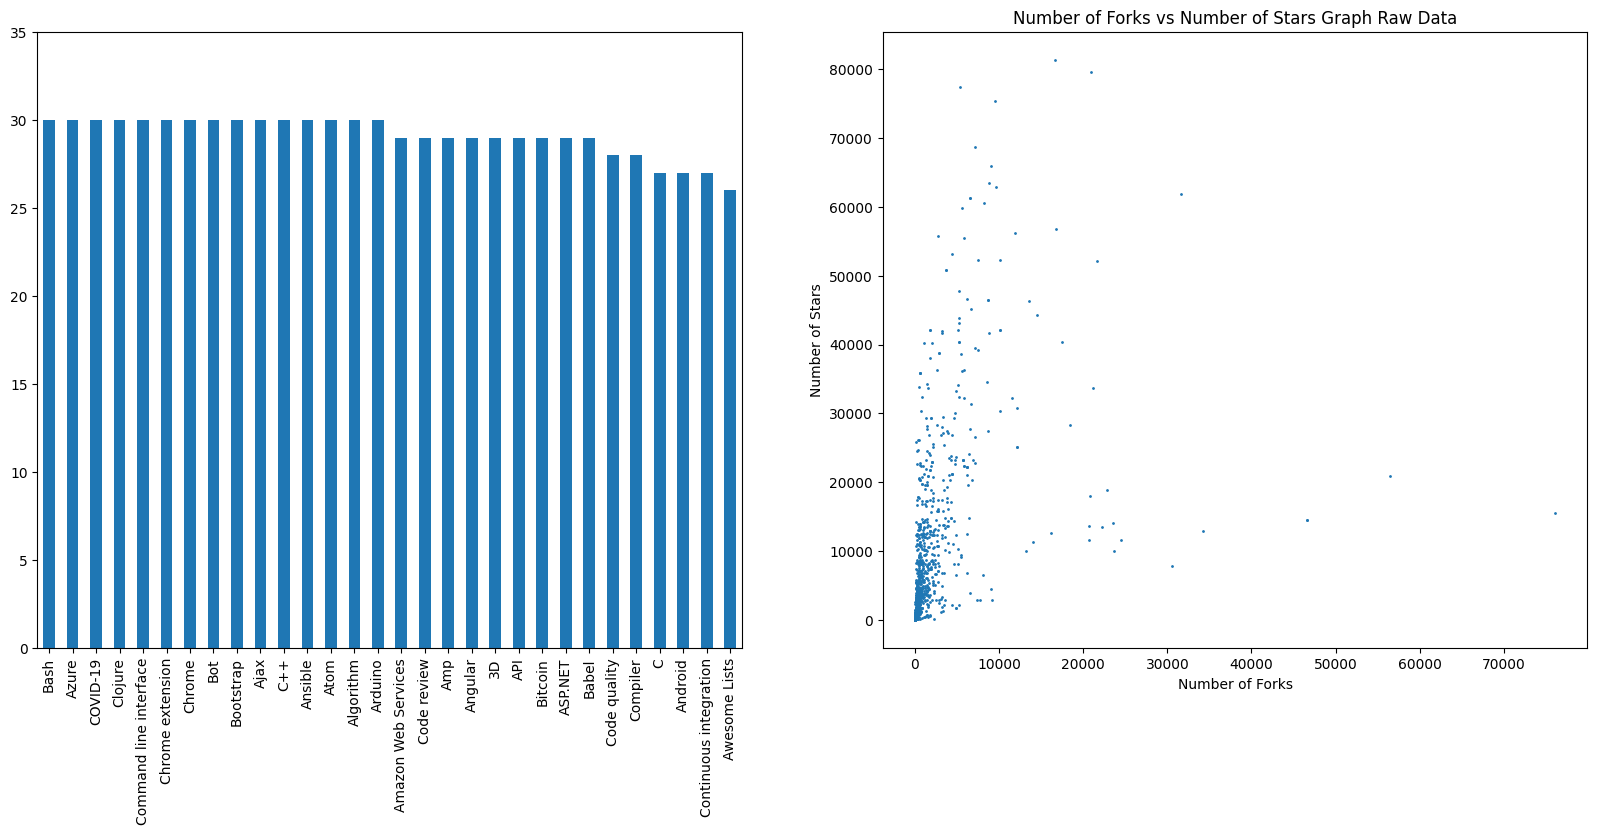

In [9]:

topics = ['3D', 'Ajax', 'Algorithm', 'Amp', 'Android', 'Angular', 'Ansible', 'API',
        'Arduino', 'ASP.NET', 'Atom', 'Awesome Lists', 'Amazon Web Services', 'Azure',
        'Babel', 'Bash', 'Bitcoin', 'Bootstrap', 'Bot', 'C', 'Chrome',
        'Chrome extension', 'Command line interface', 'Clojure', 'Code quality',
        'Code review', 'Compiler', 'Continuous integration', 'COVID-19', 'C++']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1.set_xticks(list(range(0,30))) 
ax1.set_xticklabels(topics)

df['Topics'].value_counts().plot(kind='bar', ax=ax1)
ax2.set_title("Most frequent Topics appearing in github Repositories")

ax1.set_ylim(0, 35)

ax2.set_xlabel("Number of Forks")
ax2.set_ylabel("Number of Stars")

ax2.set_title("Number of Forks vs Number of Stars Graph Raw Data")


ax2.scatter(x=df["Forks"], y=df["Stars"], s=1)


#### the most frequent topics in this repositroy seem the ones rranging from Bash to Arduino.
#### there seems to be a positive correlation between the number of forks and the number of stars a repo has. We also have a lot of outliers. The scatterplot  also tells us that there are quite a few outliers in this dataset, signifying to us that we need to clean this data a bit more before feeding it into our model.
#### This is also reflected in the box plot diagrams:



Text(0.5, 0, 'Stars')

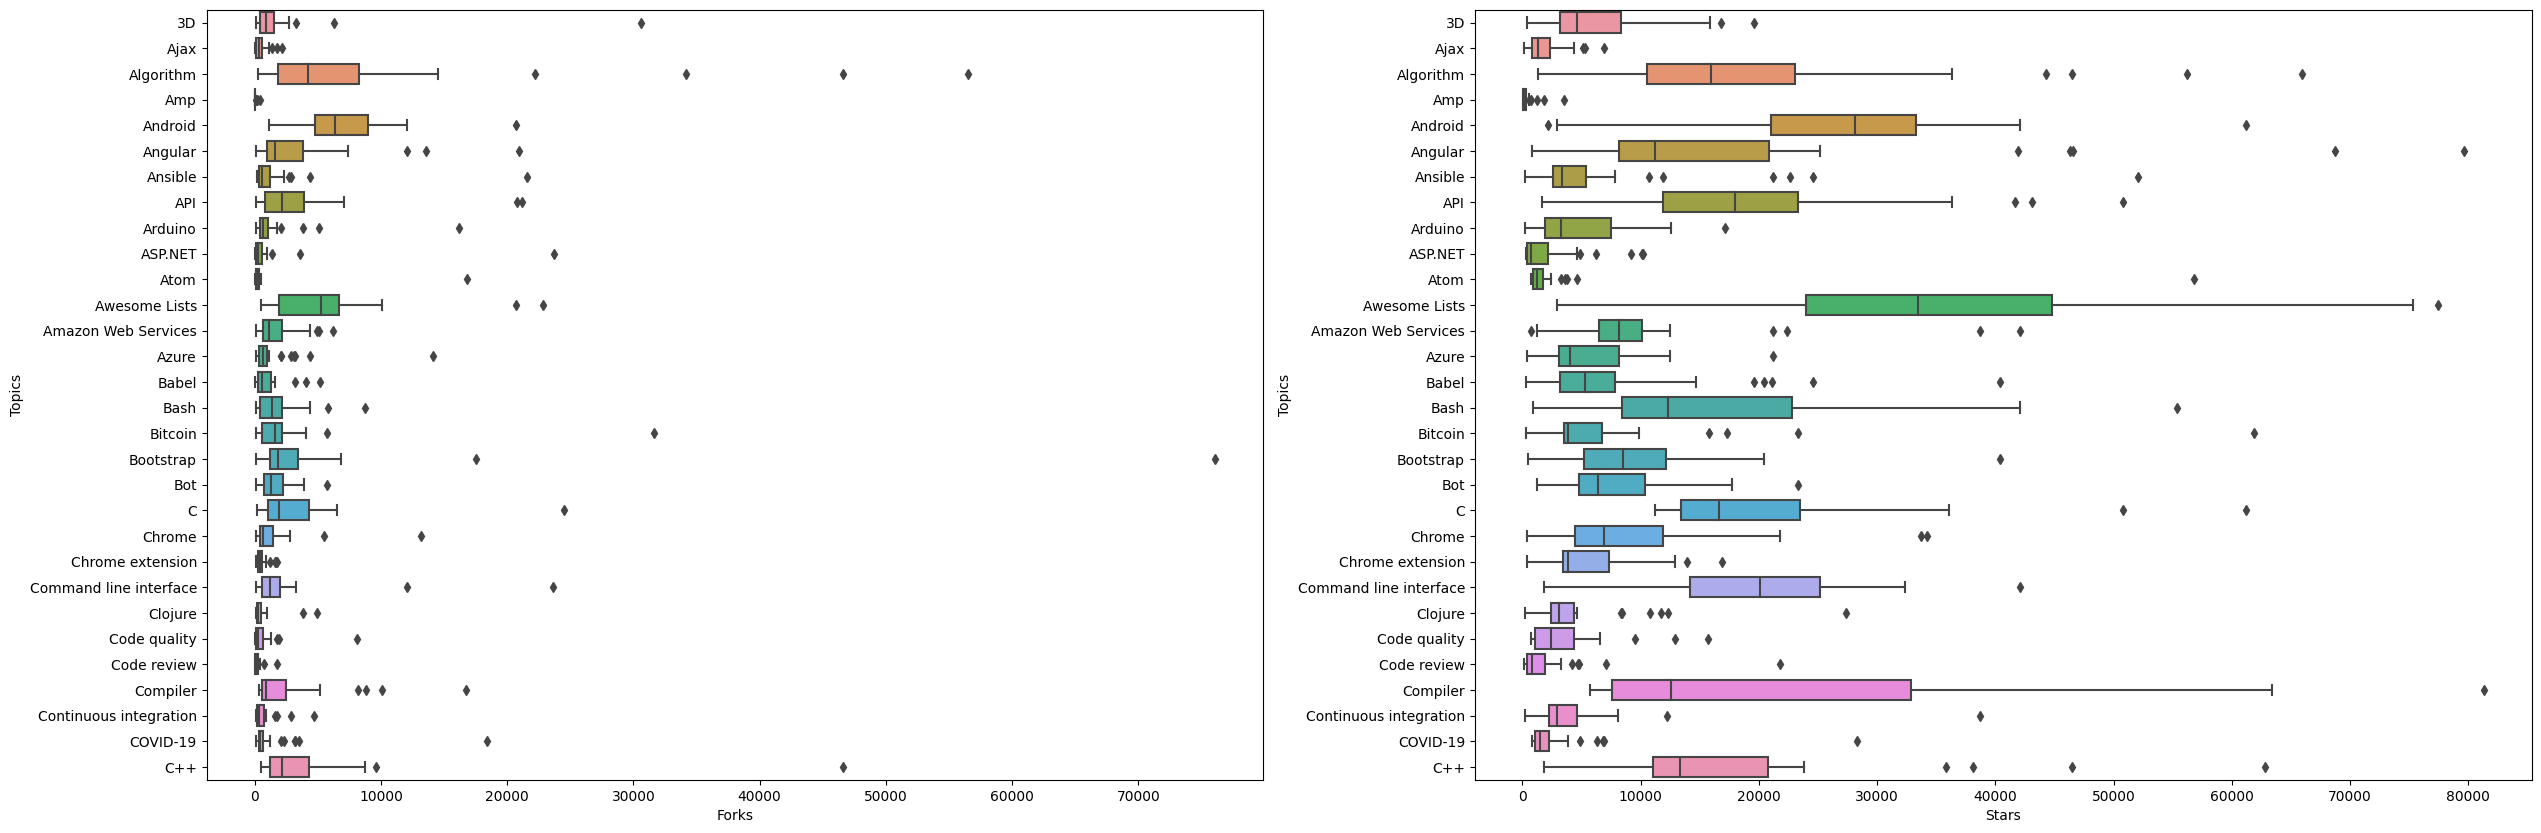

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
sns.boxplot(data=df, x="Forks", y="Topics", ax=ax1)
sns.boxplot(data=df, x="Stars", y="Topics", ax=ax2)
ax2.set_xlabel("Stars") 



#### Let's remove these outliers by using the interquartile range method.The IQR is a statistical concept describing the spread of all data points within one quartile of the average, or the middle 50 percent range. The IQR is commonly used when people want to examine what the middle group of a population is doing. When using the IQR to remove outliers you remove all points that lie outside the range defined by the quartiles +/- 1.5 * IQR. For example, consider the following calculations.

In [11]:
Q1 = df['Stars'].quantile(0.25)
Q3 = df['Stars'].quantile(0.75)
IQR_1 = Q3 - Q1 

q1 = df['Forks'].quantile(0.25)
q3 = df['Forks'].quantile(0.75)

iqr = q3-q1

first_clean_df = df[(df['Stars'] >= Q1 - 1.5 * IQR_1) & (df['Stars'] <= Q3 + 1.5 *IQR_1) & (df['Forks'] >= q1 - 1.5 * iqr) & (df['Forks'] <= q3 + 1.5 *iqr)]

##### Now that the outlier data has been removed let's have a look at the scatterplot again, and draw a heatmap to get a more quantitavide idea of how strong this correlation is:

/tmp/ipykernel_2167/1982264003.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = first_clean_df.corr()


Text(0.5, 1.0, 'Heatmaps Showing correlation between data')

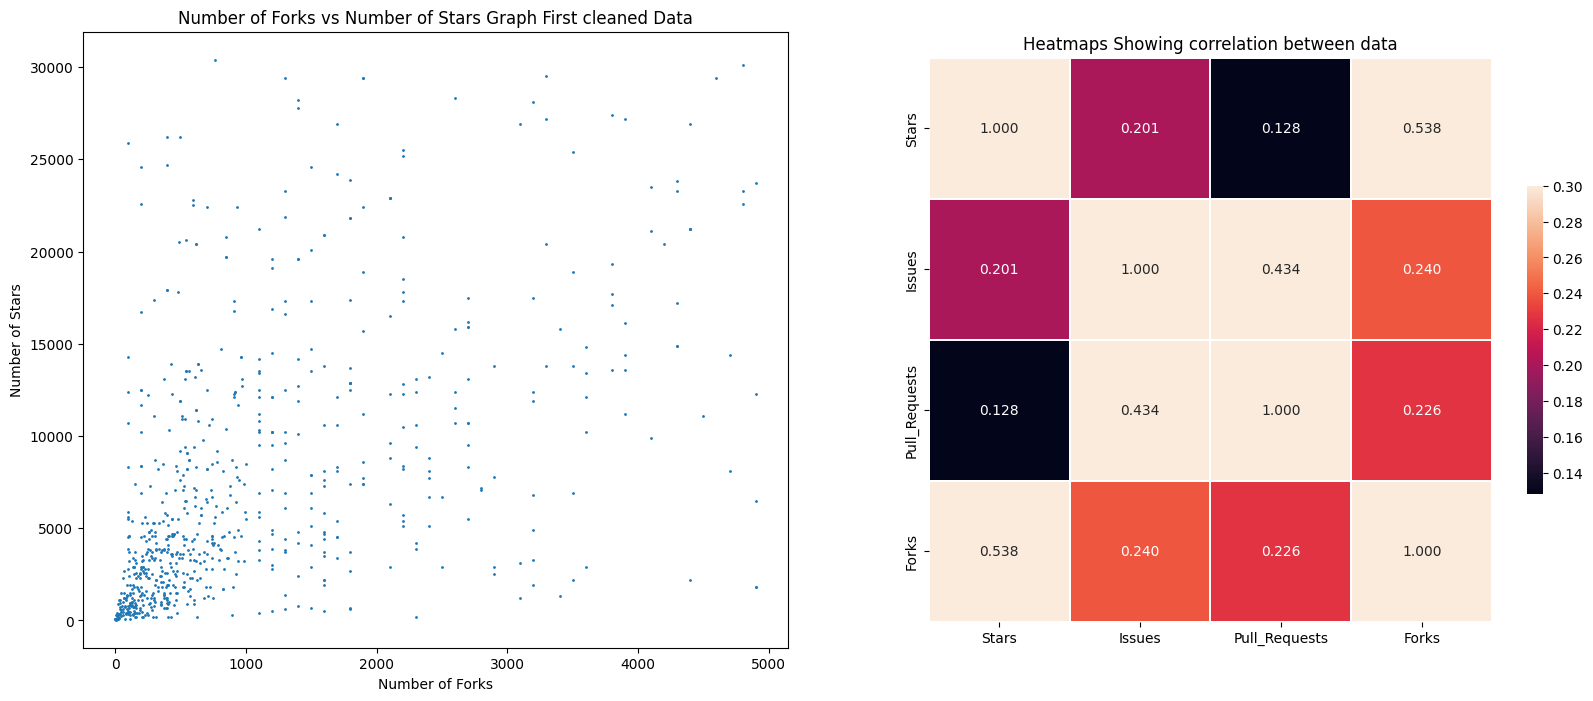

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1.scatter(first_clean_df["Forks"], first_clean_df["Stars"], s=1)
ax1.set_xlabel("Number of Forks")
ax1.set_ylabel("Number of Stars")
ax1.set_title("Number of Forks vs Number of Stars Graph First cleaned Data")

corr = first_clean_df.corr()
sns.heatmap(corr,  vmax=0.3, square=True, cbar_kws={'shrink':0.5}, fmt='.3f', linewidths='0.05', annot=True, ax=ax2)
ax2.set_title("Heatmaps Showing correlation between data")




###### #as exoected there is a strong correlation (06.49) between the number of forks an the number of stars. There is also a strong correlation between the number of issues and the number of pull requests (0.532)

#### Now let's figure out which of the topics gets the most stars (through a bar chart)

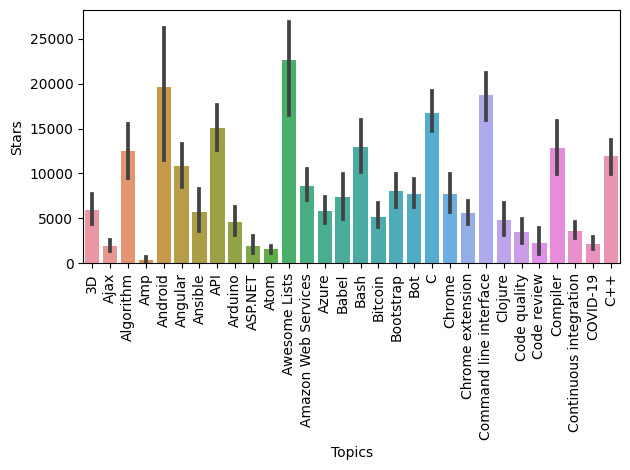

In [13]:

topics = first_clean_df["Topics"]

sns.barplot(data=first_clean_df, x="Topics", y="Stars")
plt.xticks(rotation=90)
plt.tight_layout()

### project with greatest number of stars involve awesome lists: now let's investigate which project gets the most forks

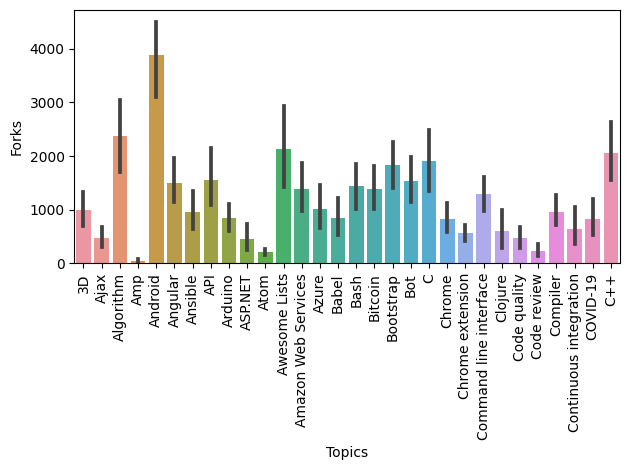

In [14]:

topics = first_clean_df["Topics"]

sns.barplot(data=first_clean_df, x="Topics", y="Forks")
plt.xticks(rotation=90)
plt.tight_layout()

##### the projects twith the greatestnumber of forks seems seem to be theones with the 'android' topic.

# Implementing the classification algorithm

In [15]:
#let's define some constants that will help us later on
column_names = ["Stars", 'Forks', "Topics", "Issues", "Pull_Requests"]

numerical_columns = ["Stars", "Forks", "Issues", "Pull_Requests"]
categorical_columns=["Topics"]

#### encoding data and preparing the Training vs testing datasets

In [16]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

2022-10-28 11:43:31.607795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 11:43:31.735771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-28 11:43:31.735852: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-28 11:43:31.756976: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-28 11:43:32.617421: W tensorflow/stream_executor/platform/de

In [17]:
first_clean_df.head()

,Stars,Issues,Pull_Requests,Forks,Topics
2,16800,18.0,4,908,3D
3,15900,72.0,11,2700,3D
4,13800,310.0,39,3300,3D
5,12100,26.0,0,1200,3D
6,12100,13.0,0,907,3D


##### encoding the categorical feature column 

In [18]:
#first encode the categorical columns
encoder = LabelEncoder()
first_clean_df['Topics']= encoder.fit_transform(first_clean_df['Topics'])


feature_columns=[]

for feature in numerical_columns:
    feature_columns.append(tf.feature_column.numeric_column(feature, dtype=tf.float32))

print(feature_columns)
first_clean_df.head(20)


[NumericColumn(key='Stars', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Forks', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Issues', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Pull_Requests', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


/tmp/ipykernel_2167/2785463303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_clean_df['Topics']= encoder.fit_transform(first_clean_df['Topics'])


,Stars,Issues,Pull_Requests,Forks,Topics
2,16800,18.0,4,908,0
3,15900,72.0,11,2700,0
4,13800,310.0,39,3300,0
5,12100,26.0,0,1200,0
6,12100,13.0,0,907,0
7,10700,734.0,67,2600,0
8,900,38.0,6,350,0
9,8300,1200.0,28,2700,0
10,7600,16.0,2,1600,0
11,700,5.0,5,387,0


##### defining the input function that will feed the data to the model

In [19]:
#define an imput function that will shuffle and feed data in batches to our model

def make_input(data_df, label_df, num_epochs=100, shuffle=True, batch_size=10):
    def input_function():
        data_set = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))#create a tf data.dataset object with data and its labels
        if shuffle:
            data_set=data_set.shuffle(1000)#shuffle data
        data_set = data_set.batch(batch_size).repeat(num_epochs) #split dataset into batches of 10 and repeat process for num of epochs
        return data_set #return a batch of the dataset
    return input_function

#### splitting the data in training and testing parts

Why scale data? Think of going to the shop to buy apples. Because we have learned about the attributes of apples and we know which are better and which are not good also we know which attributes can be compromised and which can not. So if most of the apples consist of pretty similar attributes we will take less time in the selection of the apples which directly affect the time of purchasing taken by us.

Similarly in the machine learning algorithms if the values of the features are closer to each other there are chances for the algorithm to get trained well and faster instead of the data set where the data points or features values have high differences with each other will take more time to understand the data and the accuracy will be lower.

In [20]:
#splitting the data in trianing and testing data:
X = first_clean_df.drop('Topics', axis=1)


y = first_clean_df["Topics"]
dX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler =RobustScaler()
scaler.fit(X)
X_train_sc= scaler.transform(dX_train)
X_test_sc= scaler.transform(X_test)



In [21]:
X_train_sc = pd.DataFrame(X_train_sc, columns= ["Stars", "Issues", "Pull_Requests", "Forks"])


In [22]:
X_test_sc = pd.DataFrame(X_test_sc, columns= ["Stars", "Issues", "Pull_Requests", "Forks"])

In [23]:
train_input_function = make_input(X_train_sc, y_train) #call the input function that was returned to us to get a dataset object
eval_input_function = make_input(X_test_sc, y_test, num_epochs=1, shuffle=False) #this is testing data os model only needs to see the testing data once

linear_estinmator=tf.estimator.LinearClassifier(feature_columns=feature_columns, n_classes=30)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9g601b5h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


2022-10-28 11:43:34.367041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-28 11:43:34.367084: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-28 11:43:34.367107: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (beatrixdroi-githubrepos-o894bvhaz8c): /proc/driver/nvidia/version does not exist
2022-10-28 11:43:34.370060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
linear_estinmator.train(train_input_function) #train \ above error results because you defined the feature columns and then removed Topics from the training dataset
result = linear_estinmator.evaluate(eval_input_function)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2022-10-28 11:43:35.232971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp9g601b5h/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 3.4011974, step = 0
INFO:tensorflow:global_step/sec: 618.109
INFO:tensorflow:loss = 3.2026107, step = 100 (0.163 sec)
INFO:tensorflow:global_step/sec: 975
INFO:tensorflow:loss = 3.008915, step = 200 (0.103 sec)
INFO:tensorflow:global_step/sec: 1057.13
INFO:tensorflow:loss = 3.0548947, step = 300 (0.094 sec)
INFO:tensorflow:global_step/sec: 1034.9
INFO:tensorflow:loss = 2.9631114, step = 400 (0.097 sec)
INFO:tensorflow:global_step/sec: 1043.11
INFO:tensorflow:loss = 2.7247825, step = 500 (0.096 sec)
INFO:tensorflow:global_step/sec: 1056.39
INFO:tensorflow:loss = 2.5945764, step = 600 (0.095 sec)
INFO:tensorflow:global_step/sec: 984.911
INFO:tensorflow:loss = 2.643984, step = 700 (0.101 sec)
INFO:tensorflow:global_step/sec: 1013.33
INFO:tensorfl

In [25]:
print(result) #model has been trained

{'accuracy': 0.1460177, 'average_loss': 3.1879823, 'loss': 3.1878111, 'global_step': 5300}


#### Model has been trained now let's make a prediction with it! It has an accuracy of 14.6%

In [45]:
prediction = list(linear_estinmator.predict(eval_input_function))
print(prediction[0]["probabilities"])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9g601b5h/model.ckpt-5300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[0.04288752 0.00654813 0.06117124 0.0349353  0.00307328 0.01921852
 0.01326241 0.00046706 0.01374866 0.04286477 0.05205388 0.11021044
 0.00079346 0.03520383 0.04453693 0.01567313 0.02720923 0.0100563
 0.02188189 0.00387639 0.00595159 0.040027   0.03127203 0.06591612
 0.05426546 0.05407594 0.12000354 0.00440641 0.01310529 0.0513042 ]


# Improving The Model

##### We created a Linear classifier model that would predict the github topics based on the number of forks and stars we gave it. But it has an accuracy of just of 14.6% so it can definitely be improved. Let's use a random forest classifier algorithm!

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

##### create the model and train it:

In [28]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100) 

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train_sc, y_train)


RandomForestClassifier()

##### perform the predictions and print the accuracy scores

In [29]:
# performing predictions on the test dataset
y_pred = clf.predict(X_test_sc)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.17256637168141592


#### Model is a bit better (17.25% but not much) So it appears that there isn't a great correlation between the topics and the number of forks adn stars a topic has.

# Creating a Neural Network predict the number of stars based on the number of Forks.  we are trying to predict a number so wwe are going tu use a linear regression model.

##### Let's now try to create a Neural Network that when given the number of topics, PRs, issues, commits and forks a project has can predict the number of stars a particular repo will recieve. A “neuron” in a neural network is a mathematical function that collects and classifies information according to a specific architecture. 
##### Within an artificial neural network, a neuron is a mathematical function that models the functioning of a biological neuron. Typically, a neuron compute the weighted average of its input, and this sum is passed through a nonlinear function, often called activation function, such as the sigmoid
##### To do this first start with our original dataset with the "URL", "repo name" and "repo owner" removed, and remove the outliers using the same interquartile range method that was used before

In [30]:
#starting with our data with removed outliers we have:
Q1 = df['Stars'].quantile(0.25)
Q3 = df['Stars'].quantile(0.75)
IQR_1 = Q3 - Q1 

q1 = df['Forks'].quantile(0.25)
q3 = df['Forks'].quantile(0.75)

iqr = q3-q1

second_df = df[(df['Stars'] >= Q1 - 1.5 * IQR_1) & (df['Stars'] <= Q3 + 1.5 *IQR_1) & (df['Forks'] >= q1 - 1.5 * iqr) & (df['Forks'] <= q3 + 1.5 *iqr)]


#### this is what we are left with:

In [31]:
second_df.head()

,Stars,Issues,Pull_Requests,Forks,Topics
2,16800,18.0,4,908,3D
3,15900,72.0,11,2700,3D
4,13800,310.0,39,3300,3D
5,12100,26.0,0,1200,3D
6,12100,13.0,0,907,3D


#### this time, as topics will be a feature we fit into the model, we are going to have to One hot encode it:

In [32]:
#first things first, we are going to one hot encode our categorical data:
encoded_df = pd.get_dummies(second_df.Topics, prefix='Topics')


In [33]:
encoded_df.head()

,Topics_3D,Topics_API,Topics_ASP.NET,Topics_Ajax,Topics_Algorithm,Topics_Amazon Web Services,Topics_Amp,Topics_Android,Topics_Angular,Topics_Ansible,...,Topics_C++,Topics_COVID-19,Topics_Chrome,Topics_Chrome extension,Topics_Clojure,Topics_Code quality,Topics_Code review,Topics_Command line interface,Topics_Compiler,Topics_Continuous integration
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
regression_df = pd.concat([second_df, encoded_df], axis=1)

In [35]:
regression_df.drop("Topics", axis=1, inplace=True)

##### This is what our data looks like once we have one hot encoded it.

In [36]:
regression_df.head()


,Stars,Issues,Pull_Requests,Forks,Topics_3D,Topics_API,Topics_ASP.NET,Topics_Ajax,Topics_Algorithm,Topics_Amazon Web Services,...,Topics_C++,Topics_COVID-19,Topics_Chrome,Topics_Chrome extension,Topics_Clojure,Topics_Code quality,Topics_Code review,Topics_Command line interface,Topics_Compiler,Topics_Continuous integration
2,16800,18.0,4,908,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15900,72.0,11,2700,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13800,310.0,39,3300,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,12100,26.0,0,1200,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,12100,13.0,0,907,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### next, we are going to split the data into training and testing sets and scale it using the standard scaler:

In [37]:

X_reg = regression_df.drop('Stars', axis=1)
y_reg = regression_df["Stars"]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.30, random_state=42)


#### import the relevant imports needed for this regression model:

###### code was inspired from https://www.tensorflow.org/tutorials/keras/regression

#### normalise the data

In [38]:
from tensorflow import keras
from keras import layers

#tensorflow suggests normalising the data with their normaliser before feeding it into a NN
normalizer = tf.keras.layers.Normalization(axis=1)

In [39]:
normalizer.adapt(np.array(X_reg_train))

The dense layer’s neuron in a model receives output from every neuron of its preceding layer, where neurons of the dense layer perform matrix-vector multiplication. 

In [40]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1, activation= "relu") ## recommended by tensorflow for regression problems
])

In [41]:

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [42]:
history = linear_model.fit(X_reg_train, y_reg_train, epochs=30) 

Epoch 1/30
17/17 [==============================] - 0s 1ms/step - loss: 7432.0527
Epoch 2/30
17/17 [==============================] - 0s 1ms/step - loss: 7427.3726
Epoch 3/30
17/17 [==============================] - 0s 1ms/step - loss: 7422.8955
Epoch 4/30
17/17 [==============================] - 0s 1ms/step - loss: 7418.4258
Epoch 5/30
17/17 [==============================] - 0s 1ms/step - loss: 7414.0474
Epoch 6/30
17/17 [==============================] - 0s 1ms/step - loss: 7409.6323
Epoch 7/30
17/17 [==============================] - 0s 1ms/step - loss: 7405.3911
Epoch 8/30
17/17 [==============================] - 0s 1ms/step - loss: 7401.1484
Epoch 9/30
17/17 [==============================] - 0s 1ms/step - loss: 7397.0503
Epoch 10/30
17/17 [==============================] - 0s 998us/step - loss: 7392.8633
Epoch 11/30
17/17 [==============================] - 0s 992us/step - loss: 7388.6582
Epoch 12/30
17/17 [==============================] - 0s 1ms/step - loss: 7384.5645
Epoch 13/

In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,epoch
25,7326.555176,25
26,7322.568848,26
27,7318.447266,27
28,7314.427734,28
29,7310.457520,29


In [59]:
def plot_loss(df):
  plt.plot(df["epoch"],df['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()

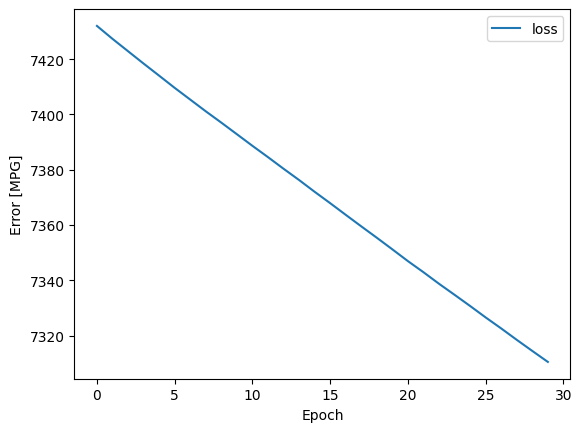

In [60]:
plot_loss(hist)